<a href="https://colab.research.google.com/github/ccosmin97/idc-prostate-mri-analysis/blob/main/project_week_39/prostate_seg_nnunet_use_case_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# nnUNet eval : Prostate segmentation on IDC collection
*   Training datasets : [ProstateX(n=30), QIN-Prostate-Repeatability(n=15)]()
*   Goal : Evaluation of a pre-trained on IDC data nnUNet whole prostate segmentation model on IDC test data, single modality T2W MRI input

Pre-trained whole prostate gland model on IDC data is for showcase only, fold0 was trained on 150 epochs and fold1 on less than 100 epochs, standard training for nnUNet involves training for 5 folds, find the best configuration and do ensemble inference with the 5 folds trained.

Please refer to [nnUNet documentation](https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/how_to_use_nnunet.md) for mentioned steps above.

# Global variables

## Global paths

In [ ]:
import os

#qin_prostate_repeatibility
os.environ["idc_root"] = os.path.join(os.getcwd(), "idc")
#prostatex
os.environ["idc_root_prostatex_dicom"] = os.path.join(os.environ["idc_root"], "prostatex", "dicom")
os.environ["idc_root_prostatex_seg_dicom"] = os.path.join(os.environ["idc_root"], "prostatex", "seg_dicom")
os.environ["idc_root_prostatex_nii"] = os.path.join(os.environ["idc_root"], "prostatex", "nii")
os.environ["idc_root_prostatex_nrrd"] = os.path.join(os.environ["idc_root"], "prostatex", "nrrd")
os.environ["idc_root_prostatex_seg_nii"] = os.path.join(os.environ["idc_root"], "prostatex", "seg_nii")
os.environ["idc_root_prostatex_seg_nii_processed"] = os.path.join(os.environ["idc_root"], "prostatex", "seg_nii_processed")
#qin prostate repeatability
os.environ["idc_root_qin_dicom"] = os.path.join(os.environ["idc_root"], "qin", "dicom")
os.environ["idc_root_qin_seg_dicom"] = os.path.join(os.environ["idc_root"], "qin", "seg_dicom")
os.environ["idc_root_qin_nii"] = os.path.join(os.environ["idc_root"], "qin", "nii")
os.environ["idc_root_qin_nrrd"] = os.path.join(os.environ["idc_root"], "qin", "nrrd")
os.environ["idc_root_qin_seg_nii"] = os.path.join(os.environ["idc_root"], "qin", "seg_nii")
os.environ["idc_root_qin_seg_nii_processed"] = os.path.join(os.environ["idc_root"], "qin", "seg_nii_processed")
#nnunet
os.environ["nnUNet"] =  os.path.join(os.getcwd(), "nnUNet")
os.environ["nnUNet_preprocessed"] =  os.path.join(os.environ["nnUNet"], "nnUNet_preprocessed")
os.environ["nnUNet_seg_preprocessed"] =  os.path.join(os.environ["nnUNet"], "nnUNet_seg_preprocessed")
# os.environ['nnUNet_raw'] = "./"#"/content/nnUNet/data/nnUNet_raw/nnUNet_raw_data"
os.environ['nnUNet_results'] = os.path.join(os.environ["nnUNet"], "pre_trained_models")
os.environ["RESULTS_FOLDER"] =  os.path.join(os.environ["nnUNet"], "results") #"/content/nnUNet/output//content/nnUNet/output/nnunet_preds"
os.environ["RESULTS_FOLDER_FOLD0"] =  os.path.join(os.environ["nnUNet"], "results", 'fold0') #"/content/nnUNet/output//content/nnUNet/output/nnunet_preds"
os.environ["RESULTS_FOLDER_FOLD1"] =  os.path.join(os.environ["nnUNet"], "results", 'fold1') #"/content/nnUNet/output//content/nnUNet/output/nnunet_preds"
#path where model pre-trained weights are stored
#misc
os.environ["IDC_Downloads"] = os.path.join(os.getcwd(), "IDC_DL")
os.environ["IDC_Downloads_Sorted"] = os.path.join(os.getcwd(), "IDC_DL_Sorted")
os.environ["IDC_SEG_Downloads"] = os.path.join(os.getcwd(), "IDC_SEG_DL")
os.environ["IDC_Downloads_SEG_Sorted"] = os.path.join(os.getcwd(), "IDC_SEG_DL_Sorted")

os.environ["logs"] = os.path.join(os.getcwd(), "logs")

#create dirs for specific folders names
for key, path in os.environ.items():
  check_patterns = [True for el in ["idc_root", "nnunet", "IDC", "nnUNet", "logs", "RESULTS_FOLDER"] if el in key]
  if True in check_patterns:
    !mkdir -p $path

# Custom functions

In [ ]:
def change_seg_labelID(input_path_nii, output_path, labelID : int):
  # Starting with SimpleITK
  img_pred = sitk.ReadImage(input_path_nii)
  npy_pred = sitk.GetArrayFromImage(img_pred)
  # Custom Python code working on a numpy array.
  npy_pred[npy_pred != 0] = labelID
  npy_pred[npy_pred !=labelID] = 0
  # Converting back to SimpleITK (assumes we didn't move the image in space as we copy the information from the original)
  res_img = sitk.GetImageFromArray(npy_pred)
  res_img.CopyInformation(img_pred)
  # Save output
  sitk.WriteImage(res_img, output_path)

In [ ]:
def parse_json_dcmqi(json_path):
  out_dic = {}
  data = json.load(open(json_path))
  for segment_dic_arr in data["segmentAttributes"]:
    dic_in = segment_dic_arr[0]
    out_dic[dic_in["SegmentedPropertyTypeCodeSequence"]["CodeMeaning"]] \
    = dic_in["labelID"]
  return out_dic

In [ ]:
def download_idc_data_serie_uid_seg(idc_df, out_folder, out_folder_sorted, out_folder_collection):
  # save the list of GCS URLs into a file
  selection_manifest = os.path.join(out_folder, "idc_manifest.txt")
  idc_df["gcs_url"].to_csv(selection_manifest, header=False, index=False)
  # !s5cmd --no-sign-request --endpoint-url https://storage.googleapis.com run $selection_manifest
  out_gsutil = out_folder+"/"
  !cat {selection_manifest} | gsutil -m cp -Ir $out_gsutil
  !python dicomsort/dicomsort.py -k -u $out_folder {out_folder_sorted}/%PatientID/%StudyInstanceUID/%SeriesInstanceUID/%SOPInstanceUID.dcm
  in_mv = out_folder_sorted+'/*'
  !mv $in_mv $out_folder_collection
  return idc_df

In [ ]:
def convert_image_dcm_to_nrrd(input_path, output_path_root, target_format="nii", prefix=""):
  if not os.path.exists(output_path_root):
    !mkdir -p $output_path_root
  !dcm2niix -z y -m y -f %i_{prefix} -o $output_path_root $input_path

In [ ]:
def convert_seg_to_nii(input_path, output_path):
  if not os.path.exists(output_path):
    !mkdir -p $output_path

  print(f'input path : {input_path}')
  print(f'output_path : {output_path}')
  !segimage2itkimage --inputDICOM $input_path --outputDirectory $output_path \
  --outputType nii

In [ ]:
def convert_dcm_sorted(input_path,output_path, idc_df):
  # path_dicom = os.environ["qin_prostate_rep_dicom"]
  for serie_folder in sorted(glob.glob(os.path.join(input_path, "**", "**", "*"))):#, recursive = True):
    path_serie_dcm_lst = glob.glob(os.path.join(serie_folder, "*.dcm"))
    modality = idc_df[idc_df["SeriesInstanceUID"] == path_serie_dcm_lst[0].split('/')[-2]]["Modality"].iloc[0]#'SEG' if pydicom.dcmread(path_serie_dcm_lst[0]).Modality == "SEG" else "MR"
    seriesInstanceUID = serie_folder.split("/")[-1]
    studyInstanceUID = serie_folder.split("/")[-2]
    patientID = serie_folder.split("/")[-3]
    print(f"Serie processed : {serie_folder}")
    print(f"SeriesDescription : {pydicom.read_file(glob.glob(os.path.join(serie_folder, '*.dcm'))[0]).SeriesDescription}")
    print(f"Modality : {pydicom.read_file(glob.glob(os.path.join(serie_folder, '*.dcm'))[0]).Modality}")
    #convert to nii
    convert_image_dcm_to_nrrd(input_path=serie_folder,
                           output_path_root=output_path,
                           prefix=f"{seriesInstanceUID}")

In [ ]:
def download_idc_data_serie_uid(idc_df, out_folder, out_folder_sorted,
                                out_folder_collection, out_folder_collection_nii):
  selection_manifest = os.path.join(out_folder, "idc_manifest.txt")
  idc_df["gcs_url"].to_csv(selection_manifest, header=False, index=False)
  # !s5cmd --no-sign-request --endpoint-url https://storage.googleapis.com run $selection_manifest
  out_gsutil = out_folder+"/"
  !cat {selection_manifest} | gsutil -m cp -Ir $out_gsutil
  !python dicomsort/dicomsort.py -k -u $out_folder {out_folder_sorted}/%PatientID/%StudyInstanceUID/%SeriesInstanceUID/%SOPInstanceUID.dcm
  #  \{os.environ["IDC_Downloads_Sorted"]}
  # !rm -rf {os.environ["qin_prostate_rep_dicom"]+"/*"}
  !mv {out_folder_sorted}/* {out_folder_collection}/
  convert_dcm_sorted(input_path=out_folder_collection,
                  output_path=out_folder_collection_nii, idc_df=idc_df)
  return idc_df

In [ ]:
def reformat_image_nnunet(in_folder, out_folder_nnunet):
  #reformats images to correct format,
  #from global path to nnunet folder==nnUNet preprocessed
  for mr_vol in glob.glob(os.path.join(in_folder, f"*.nii.gz")):
    serieUID = mr_vol.split('/')[-1].split("_")[1].replace(".nii.gz","")#.split(".")[0]
    patientID = mr_vol.split('/')[-1].split("_")[0]
    nnunet_idx = "0000" #if "T2" in mr_vol.split('/')[-2] else "0001"#0000 for T2 and 0001 for ADC
    nnunet_path = os.path.join(out_folder_nnunet,#os.environ["nnUNet_preprocessed"],
                                "_".join([patientID, serieUID, nnunet_idx]) + ".nii.gz")
    !cp $mr_vol $nnunet_path

Dataframe based quantitative metrics computation

In [ ]:
def compute_dice(pred_path, gt_path):
  #computation of dice score
  out_plast = !plastimatch dice --dice $gt_path $pred_path
  dice_score = [el[1] for el in out_plast.fields() if "DICE" in el[0]][0]#formatting by plastimatch dice output, retrieve of DSC
  return float(dice_score)

In [ ]:
def compute_hsdff(pred_path, gt_path):
  #computation of dice score
  out_plast = !plastimatch dice --hausdorff $gt_path $pred_path
  hsdff = [el[5] for el in out_plast.fields() if "Percent" in el[0] and "distance" in el[3]][0]#formatting by plastimatch hsdff output, retrieve of hsdff
  return float(hsdff)

In [ ]:
def compute_hsdff_regular(pred_path, gt_path):
  #computation of dice score
  out_plast = !plastimatch dice --hausdorff $gt_path $pred_path
  hsdff = [el[3] for el in out_plast.fields() if "Hausdorff" in el[0] and "distance" in el[1]][0]#formatting by plastimatch hsdff output, retrieve of hsdff
  return float(hsdff)

In [ ]:
def compute_avg_surface_dist(pred_path, gt_path):
  return asd(result=sitk.GetArrayFromImage(sitk.ReadImage(pred_path)), \
             reference=sitk.GetArrayFromImage(sitk.ReadImage(gt_path)))

# GOOGLE Auth login

##Colab

In [ ]:
#colab
from google.colab import auth
auth.authenticate_user()

# Setup GCP Project ID

In [ ]:
project_id = "idc-sandbox-003"
os.environ["GCP_PROJECT_ID"] = project_id
from google.cloud import bigquery
bq_client = bigquery.Client(os.environ["GCP_PROJECT_ID"])

# Setup of the Colab VM



In the following cells we will confirm you have a GPU before doing anything else, and will install and import all the Python dependencies.

The main python packages we need to install are:
* `nnunetv2` - which is the [codebase for the nn-UNet framework](https://github.com/MIC-DKFZ/nnUNet) we are going to be using for the segmentation step

## GPU checks

In [ ]:
# check wether the Colab Instance was correctly initialized with a GPU instance
gpu_list = !nvidia-smi --list-gpus

has_gpu = False if "failed" in gpu_list[0] else True

if not has_gpu:
  print("Your Colab VM does not have a GPU - check \"Runtime > Change runtime type\"")

In [ ]:
# check which model of GPU the notebook is equipped with - a Tesla K80 or T4
# T4 is the best performing on the two - and can about half the GPU processing time

!nvidia-smi

Fri Jun 30 16:21:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install command-line tools


[Plastimatch](https://plastimatch.org/index.html) is considered to be the swiss army knife of medical images processing: we will use it to convert DICOM (CT, RTSTRUCT) series to NRRD files - but it can be used for a multitude of other tasks, such as registration, resampling, cropping, and computing statistics to name a few. Plastimatch is also available as a 3DSlicer plug-in and can be used directly from the Slicer GUI.

For the sake of clarity and simplicity, we will call Plastimatch from a very simple [Python wrapper](https://github.com/denbonte/pyplastimatch) written for the occasion (unfortunately, Plastimatch does not provide an official one).

In [ ]:
%%capture
!sudo apt update

!sudo apt install plastimatch

In [ ]:
!echo $(plastimatch --version)

plastimatch version 1.8.0


[dcmqi](https://github.com/QIICR/dcmqi) is an open source library that can help with the conversion between imaging research formats and the standard DICOM representation for image analysis results. More specifically, you can use dcmqi convert DICOM Segmentation objects (DICOM SEG) into research formats, such as NIfTI and NRRD.

In [ ]:
%%capture
!wget https://github.com/QIICR/dcmqi/releases/download/v1.2.5/dcmqi-1.2.5-linux.tar.gz
!tar zxvf dcmqi-1.2.5-linux.tar.gz
!cp dcmqi-1.2.5-linux/bin/* /usr/local/bin/

Finally, we are going to install [Subversion](https://subversion.apache.org/), a tool that will allow us to clone GitHub repositories only partially (to save time and space).

In [ ]:
%%capture

!sudo apt install subversion

In [ ]:
!echo $(svn --version | head -n 2)

svn, version 1.13.0 (r1867053) compiled May 12 2022, 20:47:08 on x86_64-pc-linux-gnu


## Install Python packages

In [ ]:
%%capture
!pip install nnunetv2
!pip install pydicom
!pip install nibabel
!pip install dcm2niix
!pip install SimpleITK
!pip install medpy
!pip install seaborn

s5cmd setup

In [ ]:
!wget https://github.com/peak/s5cmd/releases/download/v2.1.0-beta.1/s5cmd_2.1.0-beta.1_Linux-64bit.tar.gz
!tar zxvf s5cmd_2.1.0-beta.1_Linux-64bit.tar.gz
!cp ./s5cmd /usr/local/bin/

Next we set up few things to help with visualization of the segmentations later.

In [ ]:
import os
import sys
import shutil
import csv
import random

import os
import glob
import json

import json
import pprint
import numpy as np
import pandas as pd

import pydicom
import SimpleITK as sitk
# import random
from random import sample
from medpy.metric.binary import asd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# PyPlastimatch - python wrapper for Plastimatch (and interactive notebook visualisation)
!svn checkout https://github.com/AIM-Harvard/pyplastimatch/trunk/pyplastimatch pyplastimatch

In [ ]:
# dicomsort is the pythong package that can sort DICOM files into
# folder organization based on user-specified DICOM attributes
!git clone https://github.com/pieper/dicomsort.git

In [ ]:
from pyplastimatch import pyplastimatch as pypla
from pyplastimatch.utils import viz as viz_utils
from pyplastimatch.utils import data as data_utils

# Prepare IDC test data for ProstateX and QIN collections

Download train data series so we omit them during evaluation process -- add to github

In [ ]:
# !gsutil -m cp -r gs://pw_39/nnunet_result/filenames_labelsTr.txt .
!wget -O filenames_labelsTr.txt https://raw.githubusercontent.com/ccosmin97/idc-prostate-mri-analysis/main/project_week_39/filenames_labelsTr.txt

--2023-06-30 17:39:16--  https://raw.githubusercontent.com/ccosmin97/idc-prostate-mri-analysis/main/project_week_39/filenames_labelsTr.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3915 (3.8K) [text/plain]
Saving to: ‘filenames_labelsTr.txt’

filenames_labelsTr. 100%[===================>]   3.82K  --.-KB/s    in 0s      

2023-06-30 17:39:16 (86.0 MB/s) - ‘filenames_labelsTr.txt’ saved [3915/3915]



In [ ]:
train_cases_df = pd.read_csv("filenames_labelsTr.txt", sep=' ', header=None, names=["seg_filename"])
train_cases_df["PatientID"] = train_cases_df.seg_filename.apply(lambda x : x.split('_')[0])
train_cases_df["T2SerieUID"] = train_cases_df.seg_filename.apply(lambda x : x.split('_')[1].replace(".nii.gz", ""))
train_cases_df.sample(10).head()

,seg_filename,PatientID,T2SerieUID
24,ProstateX-0094_1.3.6.1.4.1.14519.5.2.1.7311.51...,ProstateX-0094,1.3.6.1.4.1.14519.5.2.1.7311.5101.178750617003...
16,ProstateX-0015_1.3.6.1.4.1.14519.5.2.1.7311.51...,ProstateX-0015,1.3.6.1.4.1.14519.5.2.1.7311.5101.287403883614...
11,PCAMPMRI-00012_1.3.6.1.4.1.14519.5.2.1.3671.47...,PCAMPMRI-00012,1.3.6.1.4.1.14519.5.2.1.3671.4754.112304063989...
10,PCAMPMRI-00011_1.3.6.1.4.1.14519.5.2.1.3671.47...,PCAMPMRI-00011,1.3.6.1.4.1.14519.5.2.1.3671.4754.212083125906...
33,ProstateX-0176_1.3.6.1.4.1.14519.5.2.1.7311.51...,ProstateX-0176,1.3.6.1.4.1.14519.5.2.1.7311.5101.666342438883...


In [ ]:
refSerieUID_qin_lst = list(train_cases_df[train_cases_df["PatientID"].str.contains("PCAMPMRI")].T2SerieUID.unique())
refSerieUID_prostatex_lst = list(train_cases_df[train_cases_df["PatientID"].str.contains("ProstateX")].T2SerieUID.unique())

In [ ]:
len(refSerieUID_prostatex_lst)

30

## ProstateX

Select T2W images that have whole prostate segmentations

In [ ]:
selection_query = f"""
  -- get all prostatex segmentations objects
WITH
  prostatex_seg AS (
  SELECT
    DISTINCT(dc_all_seg.ReferencedSeriesSequence[SAFE_OFFSET(0)].SeriesInstanceUID) AS RefSerieUID
  FROM
    `bigquery-public-data.idc_v14.dicom_all` as dc_all_seg
  LEFT JOIN UNNEST(SegmentSequence) ss
  LEFT JOIN UNNEST(ss.SegmentedPropertyTypeCodeSequence) ssSptcs
  WHERE
    collection_id = 'prostatex'
  AND
    ssSptcs.CodeMeaning = 'Prostate')
SELECT
  dc_all.*
FROM
  `bigquery-public-data.idc_v14.dicom_all` AS dc_all
JOIN
  prostatex_seg
ON
  dc_all.SeriesInstanceUID = prostatex_seg.RefSerieUID
WHERE
  dc_all.collection_id = 'prostatex'
  AND dc_all.Modality = 'MR'
  AND SeriesInstanceUID NOT IN UNNEST({refSerieUID_prostatex_lst})
  AND LOWER(dc_all.SeriesDescription) LIKE '%t2%'
  """
selection_result = bq_client.query(selection_query)
selection_prostatex_df_serieUID = selection_result.result().to_dataframe()

SEG

Select SEG of reference T2W's images

In [ ]:
from google.cloud import bigquery
selection_query = f"""
SELECT
  dc_all.*,
  dc_all.ReferencedSeriesSequence[SAFE_OFFSET(0)].SeriesInstanceUID as RefSerieUID
FROM
  `bigquery-public-data.idc_v14.dicom_all` AS dc_all
LEFT JOIN UNNEST(SegmentSequence) ss
LEFT JOIN UNNEST(ss.SegmentedPropertyTypeCodeSequence) ssSptcs
WHERE
  ReferencedSeriesSequence[SAFE_OFFSET(0)].SeriesInstanceUID NOT IN UNNEST({refSerieUID_prostatex_lst})
AND Modality='SEG'
AND collection_id = 'prostatex'
AND ssSptcs.CodeMeaning = 'Prostate'
""" %refSerieUID_prostatex_lst
selection_result = bq_client.query(selection_query)
selection_t2_seg_prostatex_refSerieUID_df = selection_result.result().to_dataframe()

## QIN collection

T2W

In [ ]:
selection_query = f"""
  -- get all prostatex segmentations objects
WITH
  prostatex_seg AS (
  SELECT
    DISTINCT(dc_all_seg.ReferencedSeriesSequence[SAFE_OFFSET(0)].SeriesInstanceUID) AS RefSerieUID
  FROM
    `bigquery-public-data.idc_v14.dicom_all` as dc_all_seg
  LEFT JOIN UNNEST(SegmentSequence) ss
  LEFT JOIN UNNEST(ss.SegmentedPropertyTypeCodeSequence) ssSptcs
  WHERE
    collection_id = 'qin_prostate_repeatability'
  AND
    ssSptcs.CodeMeaning = 'Prostate')
SELECT
  dc_all.*
FROM
  `bigquery-public-data.idc_v14.dicom_all` AS dc_all
JOIN
  prostatex_seg
ON
  dc_all.SeriesInstanceUID = prostatex_seg.RefSerieUID
WHERE
  dc_all.collection_id = 'qin_prostate_repeatability'
  AND dc_all.Modality = 'MR'
  AND dc_all.SeriesDescription LIKE '%T2 Weighted Axial%'
  AND SeriesInstanceUID NOT IN UNNEST({refSerieUID_qin_lst})"""
selection_result = bq_client.query(selection_query)
selection_qin_df = selection_result.result().to_dataframe()

SEG

In [ ]:
selection_query = f"""
SELECT
  dc_all.*,
  dc_all.ReferencedSeriesSequence[SAFE_OFFSET(0)].SeriesInstanceUID as RefSerieUID
FROM
  `bigquery-public-data.idc_v14.dicom_all` AS dc_all
LEFT JOIN UNNEST(SegmentSequence) ss
LEFT JOIN UNNEST(ss.SegmentedPropertyTypeCodeSequence) ssSptcs
WHERE
  ReferencedSeriesSequence[SAFE_OFFSET(0)].SeriesInstanceUID NOT IN UNNEST({refSerieUID_qin_lst})
AND Modality='SEG'
AND collection_id = 'qin_prostate_repeatability'
AND ssSptcs.CodeMeaning = 'Prostate' """
selection_result = bq_client.query(selection_query)
selection_qin_seg_df = selection_result.result().to_dataframe()

## Download IDC data

https://learn.canceridc.dev/data/downloading-data

In [ ]:
def reset_folders():
  for key, path in os.environ.items():
    check_patterns = [True for el in ["idc_root", "IDC_Downloads", "IDC_Downloads_Sorted", "IDC"] if el in key]
    if True in check_patterns:
      !rm -rf $path
      !mkdir -p $path
  !rm /content/nnUNet/output/preds/*.nii.gz

### ProstateX

In [ ]:
#whole process
# let's make sure the download folder is clean, in case you ran this cell earlier
# for a different dataset
for serieUID_current in selection_prostatex_df_serieUID.SeriesInstanceUID.unique():
  #reset processing folders
  reset_folders()
  #download idc data
  idc_df = download_idc_data_serie_uid(idc_df=selection_prostatex_df_serieUID[selection_prostatex_df_serieUID.SeriesInstanceUID \
                                                           == serieUID_current],
                                                           out_folder=os.environ["IDC_Downloads"],
                                       out_folder_sorted=os.environ["IDC_Downloads_Sorted"],
                                       out_folder_collection=os.environ["idc_root_prostatex_dicom"],
                                       out_folder_collection_nii=os.environ["idc_root_prostatex_nii"])
  ##reformat idc input data
  reformat_image_nnunet(in_folder=os.environ["idc_root_prostatex_nii"],
                        out_folder_nnunet=os.environ["nnUNet_preprocessed"])
  ##SEG objects for corresponding T2W reference image
  #download DICOM seg objects
  idc_seg_df = download_idc_data_serie_uid_seg(idc_df=selection_t2_seg_prostatex_refSerieUID_df[selection_t2_seg_prostatex_refSerieUID_df.RefSerieUID \
                                                           == serieUID_current],
                                                           out_folder=os.environ["IDC_SEG_Downloads"],
                                       out_folder_sorted=os.environ["IDC_Downloads_SEG_Sorted"],
                                       out_folder_collection=os.environ["idc_root_prostatex_seg_dicom"])
  #Convert SEG DICOM to NIFTI
  convert_seg_to_nii(input_path=glob.glob(os.path.join(os.environ["idc_root_prostatex_seg_dicom"],
                                                       "**", "*.dcm"), recursive=True)[0],
                     output_path=os.environ["idc_root_prostatex_seg_nii"])
  idc_dic = parse_json_dcmqi(glob.glob(os.path.join(os.environ["idc_root_prostatex_seg_nii"], \
                                        "**", "*.json"), recursive=True)[0])
  path_seg_prostate_nii = glob.glob(os.path.join(os.environ["idc_root_prostatex_seg_nii"],
                                                 f"{idc_dic['Prostate']}.nii.gz"))[0]
  #change labelID to 1 -- uniform across all collection
  change_seg_labelID(path_seg_prostate_nii,
                     os.path.join(os.environ["idc_root_prostatex_seg_nii_processed"],
                                  path_seg_prostate_nii.split("/")[-1]), labelID=1)
  ref_t2_path = glob.glob(os.path.join(os.environ["nnUNet_preprocessed"],
  f"{idc_seg_df.PatientID.unique()[0]}_{idc_seg_df.RefSerieUID.unique()[0]}*.nii.gz"), recursive=True)[0]
  ##resample and reformat idc seg data
  out_path_seg_res = os.path.join(os.environ["nnUNet_seg_preprocessed"],
                                  f"{idc_seg_df.PatientID.unique()[0]}_{idc_seg_df.RefSerieUID.unique()[0]}.nii.gz")
  resample_args_to_t2_origin = {"input" : os.path.join(os.environ["idc_root_prostatex_seg_nii_processed"],
                                  path_seg_prostate_nii.split("/")[-1]),
                        "output" : out_path_seg_res,
                        "fixed" : ref_t2_path,
                        "interpolation" : "nn"}
  pypla.resample(verbose = True, **resample_args_to_t2_origin)
  # !cp -r {os.environ["idc_root_prostatex_seg_nii_resampled"]}/*.nii.gz {os.environ["nnUNet_seg_preprocessed"]}/

### QIN

In [ ]:
#whole process
# let's make sure the download folder is clean, in case you ran this cell earlier
# for a different dataset
for serieUID_current in selection_qin_df.SeriesInstanceUID.unique():
  #reset processing folders
  reset_folders()
  #download idc data
  idc_df = download_idc_data_serie_uid(idc_df=selection_qin_df[selection_qin_df.SeriesInstanceUID \
                                                           == serieUID_current],
                                                           out_folder=os.environ["IDC_Downloads"],
                                       out_folder_sorted=os.environ["IDC_Downloads_Sorted"],
                                       out_folder_collection=os.environ["idc_root_qin_dicom"],
                                       out_folder_collection_nii=os.environ["idc_root_qin_nii"])
  ##reformat idc input data
  reformat_image_nnunet(in_folder=os.environ["idc_root_qin_nii"],
                        out_folder_nnunet=os.environ["nnUNet_preprocessed"])
  ##SEG objects for corresponding T2W reference image
  idc_seg_df = download_idc_data_serie_uid_seg(idc_df=selection_qin_seg_df[selection_qin_seg_df.RefSerieUID \
                                                           == serieUID_current],
                                                           out_folder=os.environ["IDC_SEG_Downloads"],
                                       out_folder_sorted=os.environ["IDC_Downloads_SEG_Sorted"],
                                       out_folder_collection=os.environ["idc_root_qin_seg_dicom"])
  convert_seg_to_nii(input_path=glob.glob(os.path.join(os.environ["idc_root_qin_seg_dicom"],
                                                       "**", "*.dcm"), recursive=True)[0],
                     output_path=os.environ["idc_root_qin_seg_nii"])
  idc_dic = parse_json_dcmqi(glob.glob(os.path.join(os.environ["idc_root_qin_seg_nii"], \
                                        "**", "*.json"), recursive=True)[0])
  path_seg_prostate_nii = glob.glob(os.path.join(os.environ["idc_root_qin_seg_nii"],
                                                 f"{idc_dic['Prostate']}.nii.gz"))[0]
  #change labelID to 1 -- uniform across all collection
  change_seg_labelID(path_seg_prostate_nii,
                     os.path.join(os.environ["idc_root_qin_seg_nii_processed"],
                                  path_seg_prostate_nii.split("/")[-1]), labelID=1)
  ref_t2_path = glob.glob(os.path.join(os.environ["nnUNet_preprocessed"],
  f"{idc_seg_df.PatientID.unique()[0]}_{idc_seg_df.RefSerieUID.unique()[0]}*.nii.gz"), recursive=True)[0]
  out_path_seg_res = os.path.join(os.environ["nnUNet_seg_preprocessed"],
                                  f"{idc_seg_df.PatientID.unique()[0]}_{idc_seg_df.RefSerieUID.unique()[0]}.nii.gz")
  resample_args_to_t2_origin = {"input" : os.path.join(os.environ["idc_root_qin_seg_nii_processed"],
                                  path_seg_prostate_nii.split("/")[-1]),
                        "output" : out_path_seg_res,
                        "fixed" : ref_t2_path,
                        "interpolation" : "nn"}
  pypla.resample(verbose = True, **resample_args_to_t2_origin)

### Prostate MRI US Biopsy

# NNUNET EVAL

## Paths and folder creating

Path to model and install

Pre-trained model upload to google drive

In [ ]:
seg_model_url = "https://www.dropbox.com/scl/fi/dts193nps4fp1ue1qrcgw/Dataset999_ProstateIDC.zip?dl=0&rlkey=j39xp2s0imrprnq34d7exybz2"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1N3z6RhP4rjkojsh1y1w5F1vkaLfov2uT' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1N3z6RhP4rjkojsh1y1w5F1vkaLfov2uT" -O model.zip && rm -rf /tmp/cookies.txt
!unzip -d {os.environ['nnUNet_results']}/ model.zip

## Inference using nnUNet pre-trained models

Only two folds were trained, standard procedure for nnUNet is 5 fold cross validation training, this is for demonstration purposes

Fold 0 prediction

In [ ]:
!nnUNetv2_predict -i {os.environ["nnUNet_preprocessed"]} \
                -o {os.environ["RESULTS_FOLDER_FOLD0"]} \
                -d 999 -c 3d_fullres \
                --save_probabilities -f 0 -chk checkpoint_best.pth --verbose

Fold 1 prediction

In [ ]:
!nnUNetv2_predict -i {os.environ["nnUNet_preprocessed"]} \
                -o {os.environ["RESULTS_FOLDER_FOLD1"]} \
                -d 999 -c 3d_fullres \
                --save_probabilities -f 1 -chk checkpoint_best.pth --verbose

## Evaluation

In [ ]:
df_results = pd.DataFrame()

Fold 0

In [ ]:
#whole process
for caseID_current in glob.glob(os.path.join(os.environ["RESULTS_FOLDER_FOLD0"], "*.nii.gz")):#not_processed_RefSerieUID
  #reset processing folders
  #get caseID
  caseID = caseID_current.split("/")[-1][:-7]
  print(f"caseID processed : {caseID} ...")
  #find ref T2 volume
  t2_path = glob.glob(os.path.join(os.environ["nnUNet_preprocessed"], f"*{caseID}*.nii.gz"))[0]
  #find expert SEG T2 volume
  t2_seg_expert_path = glob.glob(os.path.join(os.environ["nnUNet_seg_preprocessed"], f"*{caseID}*.nii.gz"))[0]
  dict_case = {"RefSerieUID": serieUID_current, "dice_score": compute_dice(caseID_current, t2_seg_expert_path), \
        "hsdff" : compute_hsdff_regular(caseID_current, t2_seg_expert_path), \
        "hsdff_95" : compute_hsdff(caseID_current, t2_seg_expert_path), \
        "asd" : compute_avg_surface_dist(caseID_current, t2_seg_expert_path),\
        "regions" : "Prostate",
        "fold" : "0",
        "caseID" : caseID}
  df_results = pd.concat([df_results, pd.DataFrame([dict_case])], ignore_index=True)
  print("Done! \n")

Fold 1

In [ ]:
#whole process
for caseID_current in glob.glob(os.path.join(os.environ["RESULTS_FOLDER_FOLD1"], "*.nii.gz")):#not_processed_RefSerieUID
  # get caseID
  caseID = caseID_current.split("/")[-1][:-7]
  print(f"caseID processed : {caseID} ...")
  #find ref T2 volume
  t2_path = glob.glob(os.path.join(os.environ["nnUNet_preprocessed"], f"*{caseID}*.nii.gz"))[0]
  #find expert SEG T2 volume
  t2_seg_expert_path = glob.glob(os.path.join(os.environ["nnUNet_seg_preprocessed"], f"*{caseID}*.nii.gz"))[0]
  dict_case = {"RefSerieUID": serieUID_current, "dice_score": compute_dice(caseID_current, t2_seg_expert_path), \
        "hsdff" : compute_hsdff_regular(caseID_current, t2_seg_expert_path), \
        "hsdff_95" : compute_hsdff(caseID_current, t2_seg_expert_path), \
        "asd" : compute_avg_surface_dist(caseID_current, t2_seg_expert_path),\
        "regions" : "Prostate",
        "fold" : "1",
        "caseID" : caseID}
  df_results = pd.concat([df_results, pd.DataFrame([dict_case])], ignore_index=True)
  print("Done! \n")

In [ ]:
df_results.sample(3).head()

,RefSerieUID,dice_score,hsdff,hsdff_95,asd,regions,fold,caseID
15,1.3.6.1.4.1.14519.5.2.1.3671.4754.105976129314...,0.957285,4.358899,0.250000,0.402593,Prostate,0,ProstateX-0066_1.3.6.1.4.1.14519.5.2.1.7311.51...
22,1.3.6.1.4.1.14519.5.2.1.3671.4754.105976129314...,0.940552,5.625000,0.562500,0.794228,Prostate,0,ProstateX-0265_1.3.6.1.4.1.14519.5.2.1.7310.51...
79,1.3.6.1.4.1.14519.5.2.1.3671.4754.105976129314...,0.936606,4.500000,0.790569,0.721460,Prostate,1,ProstateX-0007_1.3.6.1.4.1.14519.5.2.1.7311.51...


Plot dice score results

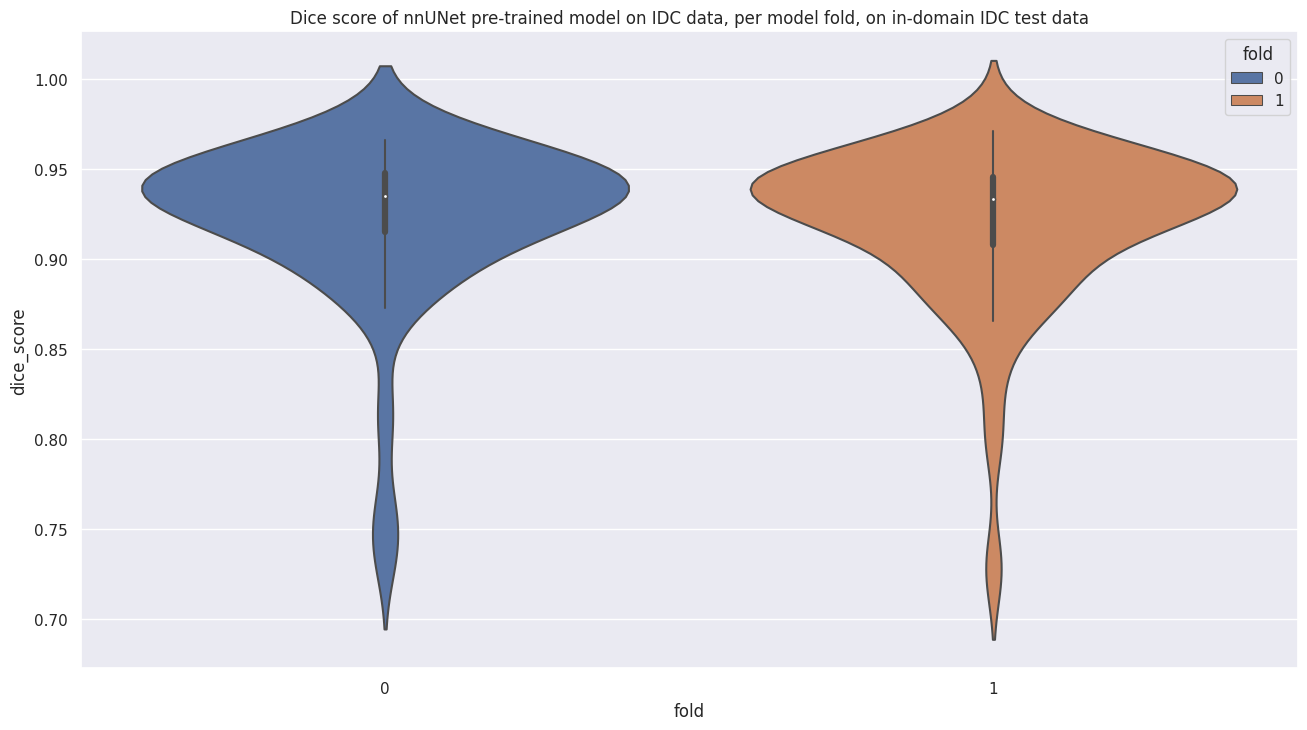

In [ ]:
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.violinplot(x=df_results["fold"],
               y=df_results["dice_score"], dodge=False,
               hue=df_results["fold"]).set(title="Dice score of nnUNet pre-trained model on IDC data, per model fold, on in-domain IDC test data")
plt.show()

Hausdorff distance(95%) results

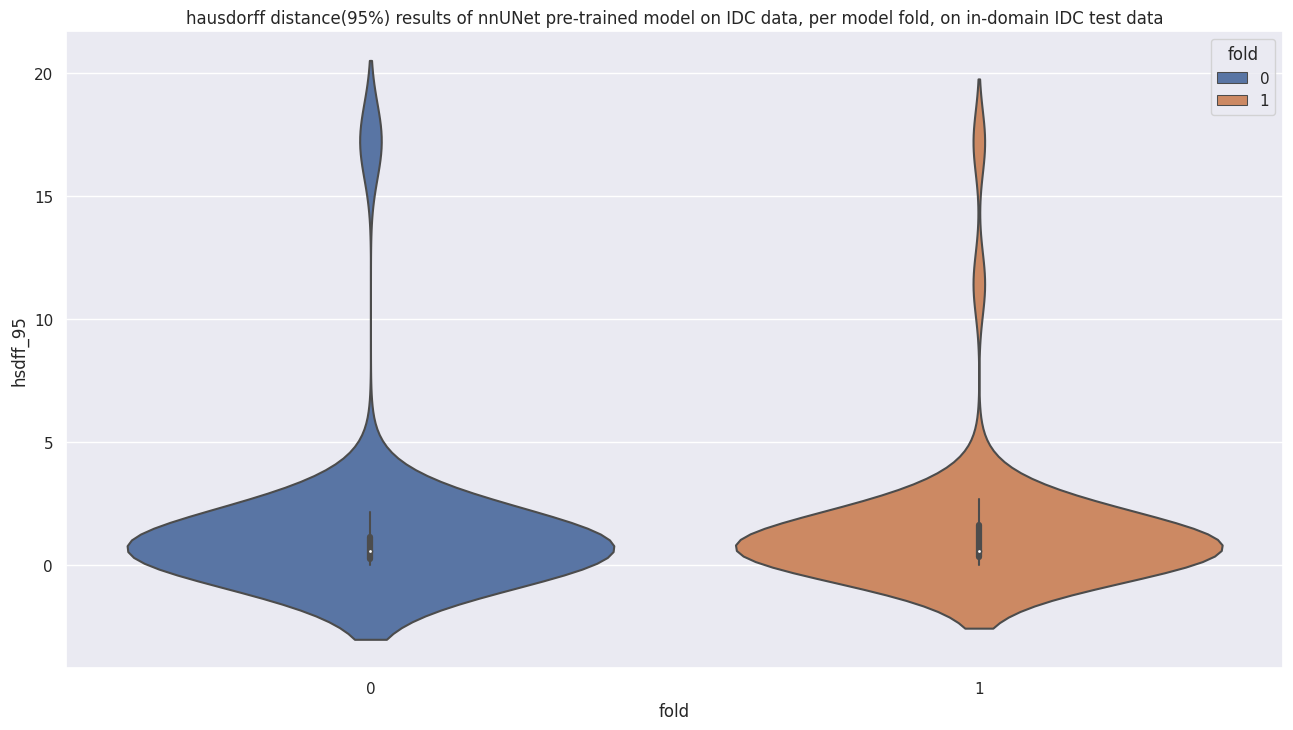

In [ ]:
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.violinplot(x=df_results["fold"],
               y=df_results["hsdff_95"], dodge=False,
               hue=df_results["fold"]).set(title="hausdorff distance(95%) results of nnUNet pre-trained model on IDC data, per model fold, on in-domain IDC test data")
plt.show()

Average surface distance results

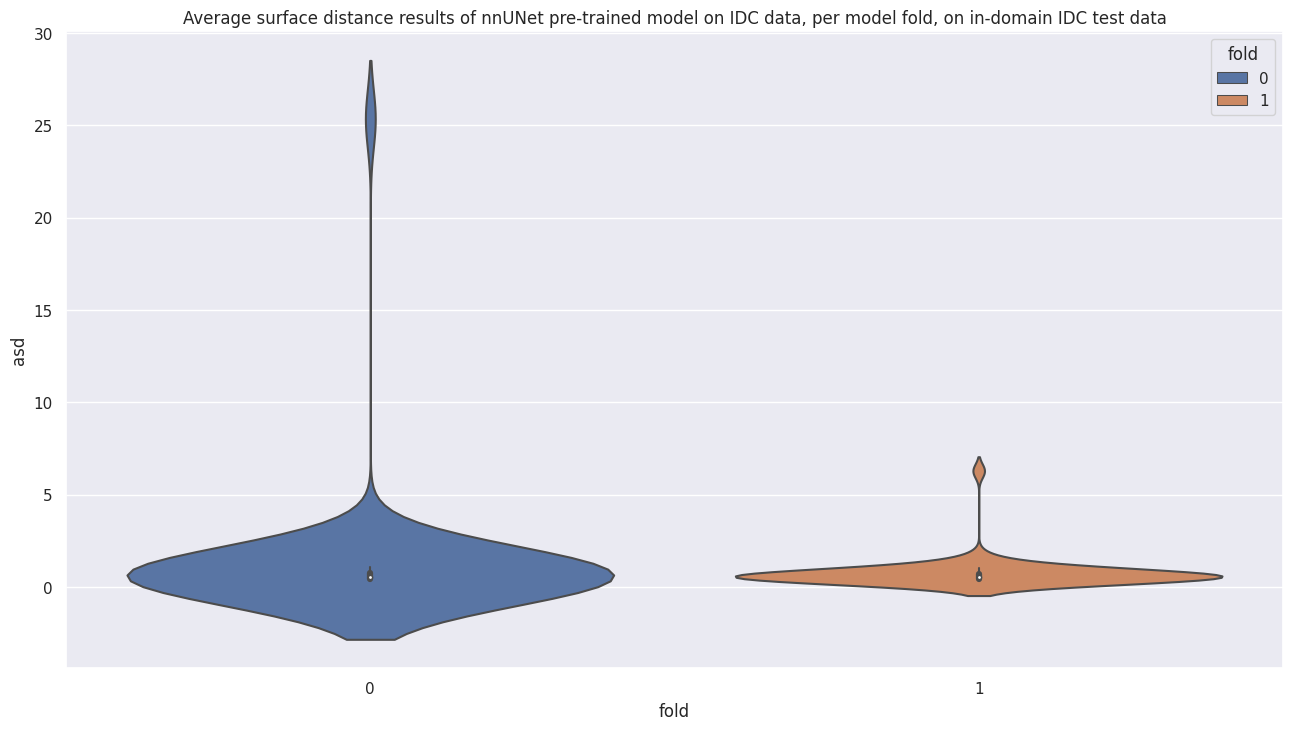

In [ ]:
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.violinplot(x=df_results["fold"],
               y=df_results["asd"], dodge=False,
               hue=df_results["fold"]).set(title="Average surface distance results of nnUNet pre-trained model on IDC data, per model fold, on in-domain IDC test data")
plt.show()